In [1]:
# mostly pulled from hls4ml_3.ipynb and waveform_demo.ipynb
# last updated 2025-05-05 by mza
name = "mza_try5"
num_epochs = 10000
batch_size = 1000
hidden_nodes = [ 64 ]
hidden_node_type = "relu"
truths_to_use = [ 2 ] # t_peak, t_sigma, height, pedestal
use_pruning = False
prune_ratio = 0.1
train = True
synth_hls = True
input_quantization = 9
inner_quantization = 9
output_quantization = 9
integer_part = 1
default_quantization = 9
default_integer_part = 3

In [2]:
import os, errno
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['PATH'] = os.environ['XILINX_VIVADO'] + '/bin:' + os.environ['PATH']
import numpy as np
seed = 0
np.random.seed(seed)
import matplotlib.pyplot as plt
try:
    os.mkdir(name)
except OSError as exception:
    if exception.errno != errno.EEXIST:
        raise

In [3]:
dataset1 = np.load('waveform_data_0.npy') # (10000, 104)
dataset2 = np.load('waveform_data_1.npy') # (10000, 104)
dataset = np.concatenate((dataset1, dataset2))
num_waveforms = len(dataset)
training_quantity = int(0.8 * num_waveforms)
num_truths = 4
time_samples = len(dataset[0]) - num_truths
print("num_waveforms: " + str(num_waveforms))
num_truths_to_use = len(truths_to_use)
print("num_truths_to_use: " + str(num_truths_to_use))
waveforms = dataset[:,num_truths:]
truths = dataset[:,:num_truths]
waveform_min = min([ min(waveforms[i]) for i in range(len(waveforms)) ])
waveform_max = max([ max(waveforms[i]) for i in range(len(waveforms)) ])
offset = waveform_min
gain = 1.0 / (waveform_max - waveform_min)
scaled_waveforms = np.array([ [ gain * (waveforms[j,i] - offset) for i in range(time_samples) ] for j in range(num_waveforms) ])
scaled_truths = np.array([ [ truths[j,0]/time_samples, truths[j,1]/time_samples, gain * (truths[j,2] - offset), gain * (truths[j,3] - offset) ] for j in range(num_waveforms) ])
train_data = scaled_waveforms[:training_quantity,:]
print("train_data.shape: " + str(train_data.shape))
train_truth = scaled_truths[:training_quantity,truths_to_use]
print("train_truth.shape: " + str(train_truth.shape))
test_data = scaled_waveforms[training_quantity:,:]
print("test_data.shape: " + str(test_data.shape))
test_truth = scaled_truths[training_quantity:,truths_to_use]
print("test_truth.shape: " + str(test_truth.shape))

num_waveforms: 20000
num_truths_to_use: 1
train_data.shape: (16000, 100)
train_truth.shape: (16000, 1)
test_data.shape: (4000, 100)
test_truth.shape: (4000, 1)


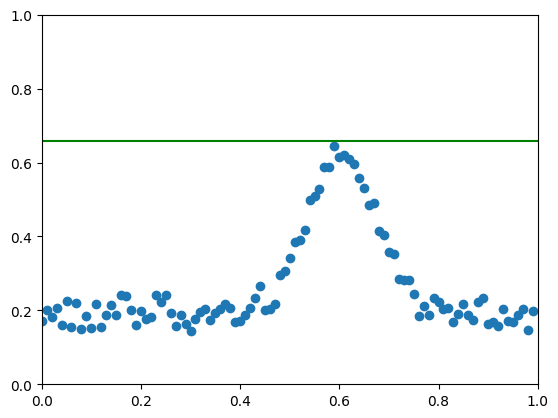

In [37]:
evt = 8
if 1:
    x = np.zeros(time_samples)
    for i in range(time_samples):
        x[i] = i/time_samples
    y = train_data[evt]
    plt.xlim(0, 1), plt.ylim(0, 1)
    plt.scatter(x, y)
    plt.plot([0.0, 1.0], [scaled_truths[evt][3] + scaled_truths[evt][2], scaled_truths[evt][3] + scaled_truths[evt][2]], color="green")
    plt.show()

In [6]:
import tensorflow as tf
tf.random.set_seed(seed)
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l1
from tensorflow.keras.layers import Activation
from tensorflow.keras import optimizers
from callbacks import all_callbacks
from qkeras.qlayers import QDense, QActivation
from qkeras.quantizers import quantized_bits, quantized_relu, quantized_sigmoid

In [7]:
#, symmetric=1, keep_negative=1
input_quantizer = quantized_bits(bits=input_quantization, integer=integer_part, alpha=1)
inner_quantizer = quantized_bits(inner_quantization, integer_part, alpha=1)
output_quantizer = quantized_bits(output_quantization, integer_part, alpha=1)
Q = "RND_CONV"
O = "SAT"
N = "0"
default_quantization_string = 'ap_fixed<' + str(default_quantization) + ',' + str(default_integer_part) + ',' + Q + ',' + O + ',' + N + '>'
output_quantization_string = 'ap_fixed<' + str(output_quantization) + ',' + str(integer_part) + ',' + Q + ',' + O + ',' + N + '>'
if hidden_node_type=="relu":
    hidden_activations = [ quantized_relu(bits=inner_quantization) for i in range(len(hidden_nodes)) ]
else:
    hidden_activations = [ quantized_sigmoid(bits=inner_quantization) for i in range(len(hidden_nodes)) ]
hidden_names = [ hidden_node_type for i in range(len(hidden_nodes)) ]
model = Sequential()
model.add(QDense(time_samples, input_shape=(time_samples,), name='input_qdense', kernel_quantizer=input_quantizer, bias_quantizer=input_quantizer, kernel_initializer='glorot_uniform'))
model.add(QActivation(activation=quantized_sigmoid(bits=input_quantization), name='input_sigmoid'))
for i in range(len(hidden_nodes)):
    model.add(QDense(hidden_nodes[i], name=hidden_names[i] + str(i) + "qdense", kernel_quantizer=inner_quantizer, bias_quantizer=inner_quantizer, kernel_initializer='glorot_uniform'))
    model.add(QActivation(activation=hidden_activations[i], name=hidden_names[i] + str(i) + "activation"))
model.add(QDense(num_truths_to_use, name='output_qdense', kernel_quantizer=output_quantizer, bias_quantizer=output_quantizer, kernel_initializer='glorot_uniform'))
if num_truths_to_use<2:
    model.add(Activation(activation='sigmoid', name='output_sigmoid'))
else:
    model.add(Activation(activation='softmax', name='output_softmax'))

In [8]:
if use_pruning:
    from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
    from tensorflow_model_optimization.sparsity.keras import strip_pruning
    # the first argument is the percentage of the weights that will be forced to be 0
    pruning_params = {"pruning_schedule": pruning_schedule.ConstantSparsity(prune_ratio, begin_step=2000, frequency=100)}
    model = prune.prune_low_magnitude(model, **pruning_params)

In [9]:
if train:
    #optimizer = optimizers.Adam(learning_rate=0.0001)
    optimizer = optimizers.SGD(learning_rate=0.1)
    #model.compile(optimizer=optimizer, loss=['categorical_crossentropy'], metrics=['accuracy'])
    model.compile(optimizer=optimizer, loss=['mse'])
    if use_pruning:
        callbacks = all_callbacks(stop_patience=1000, lr_factor=0.5, lr_patience=10, lr_epsilon=0.000001, lr_cooldown=2, lr_minimum=0.0000001, outputDir=name)
        callbacks.callbacks.append(pruning_callbacks.UpdatePruningStep())
        model.fit(train_data, train_truth, batch_size=batch_size, epochs=num_epochs, validation_split=0.25, shuffle=False, callbacks=callbacks.callbacks, verbose=0)
    else:
        model.fit(train_data, train_truth, batch_size=batch_size, epochs=num_epochs, validation_split=0.25, shuffle=False, verbose=0)
    #loss, acc = model.evaluate(test_data, test_truth, verbose=0)
    if use_pruning:
        model = strip_pruning(model)
    model.save(name + '/KERAS_check_best_model.keras')
else:
    from tensorflow.keras.models import load_model
    from qkeras.utils import _add_supported_quantized_objects
    co = {}
    _add_supported_quantized_objects(co)
    model = load_model(name + '/KERAS_check_best_model.keras', custom_objects=co) # TypeError: <qkeras.qlayers.QActivation object at 0x774300567100> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

/root/anaconda3/envs/hls4ml-tutorial/lib/python3.10/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(


In [10]:
#print('test_acc: {:.3f}, test_loss: {:.3f}'.format(acc, loss))
train_prediction = model.predict(train_data)
test_prediction = model.predict(test_data)

125/125 [==============================] - 0s 597us/step


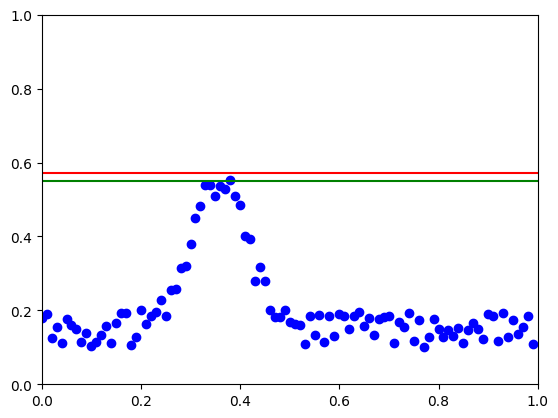

In [47]:
evt = 6
if 1:
    x = np.zeros(time_samples)
    for i in range(time_samples):
        x[i] = i/time_samples
    y = train_data[evt]
    plt.xlim(0, 1), plt.ylim(0, 1)
    plt.scatter(x, y, color="blue")
    plt.plot([0.0, 1.0], [scaled_truths[evt][3] + scaled_truths[evt][2], scaled_truths[evt][3] + scaled_truths[evt][2]], color="green")
    plt.plot([0.0, 1.0], [scaled_truths[evt][3] + train_prediction[evt][0], scaled_truths[evt][3] + train_prediction[evt][0]], color="red")
    plt.show()

In [12]:
import csv
with open(name + '/Input.dat', 'w') as f:
    csv.writer(f, delimiter=' ').writerows(test_data)
with open(name + '/Output.dat', 'w') as f:
    csv.writer(f, delimiter=' ').writerows(test_prediction)

In [49]:
import hls4ml, plotting
config = hls4ml.utils.config_from_keras_model(model, granularity='name')
config['LayerName']['output_sigmoid']['exp_table_t'] = output_quantization_string
config['LayerName']['output_sigmoid']['inv_table_t'] = output_quantization_string
config['LayerName']['output_sigmoid']['Precision']   = output_quantization_string
config['IOType'] = 'io_parallel'
config['Model']['Precision']['default'] = default_quantization_string
config['Model']['Strategy'] = 'Resource'
config['Model']['ReuseFactor'] = 64 # Valid ReuseFactor(s): 1,2,4,8,16,32,64
config['LayerName']['input_qdense']['ReuseFactor'] = 200 # Valid ReuseFactor(s): 1,2,4,5,10,20,25,50,100,200,400,500,1000,2000,2500,5000,10000
config['LayerName']['relu0qdense']['ReuseFactor'] = 200 # Valid ReuseFactor(s): 1,2,4,5,10,20,25,50,100,200,400,800,1600,3200,6400
config['Model']['TraceOutput'] = True
for layer in config['LayerName'].keys():
    config['LayerName'][layer]['Trace'] = True
plotting.print_dict(config)
hls_model = hls4ml.converters.convert_from_keras_model(
    model, hls_config=config, output_dir=name + '/hls4ml_prj', part='xc7z020clg400-1',
    input_data_tb = name + "/Input.dat", output_data_tb = name + "/Output.dat", backend='Vitis', verbose=0
)

Interpreting Sequential
Topology:
Layer name: input_qdense_input, layer type: InputLayer, input shapes: [[None, 100]], output shape: [None, 100]
Layer name: input_qdense, layer type: QDense, input shapes: [[None, 100]], output shape: [None, 100]
Layer name: input_sigmoid, layer type: HardActivation, input shapes: [[None, 100]], output shape: [None, 100]
Layer name: relu0qdense, layer type: QDense, input shapes: [[None, 100]], output shape: [None, 64]
Layer name: relu0activation, layer type: Activation, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: output_qdense, layer type: QDense, input shapes: [[None, 64]], output shape: [None, 1]
Layer name: output_sigmoid, layer type: Activation, input shapes: [[None, 1]], output shape: [None, 1]
Model
  Precision
    default:         ap_fixed<9,3,RND_CONV,SAT,0>
  ReuseFactor:       64
  Strategy:          Resource
  BramFactor:        1000000000
  TraceOutput:       True
LayerName
  input_qdense_input
    Trace:           True


/root/anaconda3/envs/hls4ml-tutorial/lib/python3.10/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(


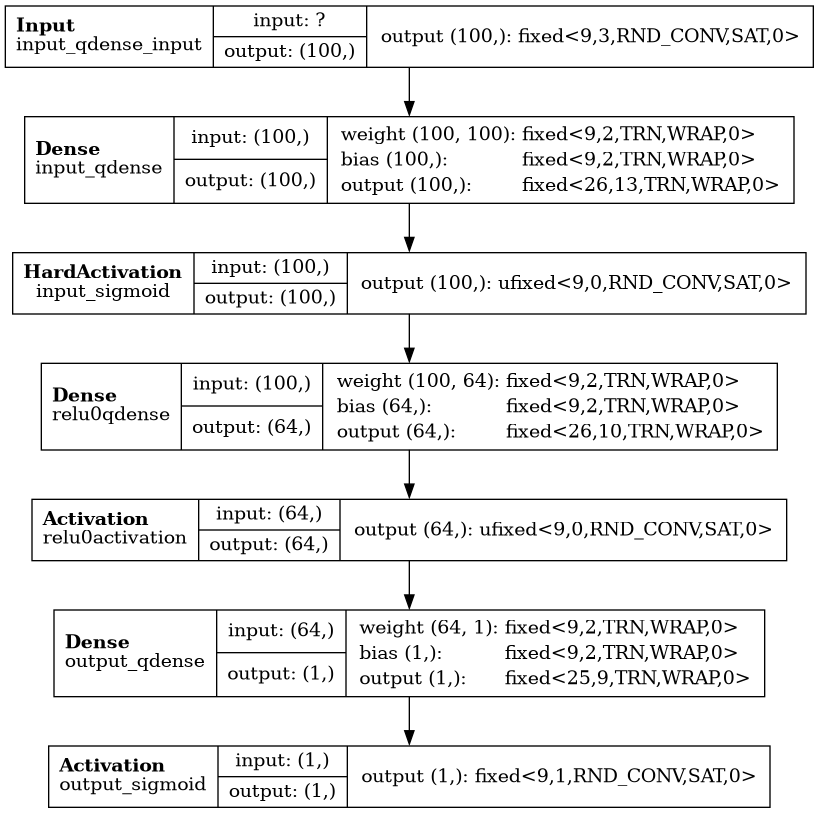

In [50]:
from IPython.display import Image
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=name + '/hls_model.png')
Image(name + '/hls_model.png')

In [51]:
hls_model.compile()

Writing HLS project
Done


/root/anaconda3/envs/hls4ml-tutorial/lib/python3.10/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(


In [52]:
hls_train_prediction = hls_model.predict(np.ascontiguousarray(train_data))
hls_test_prediction = hls_model.predict(np.ascontiguousarray(test_data))

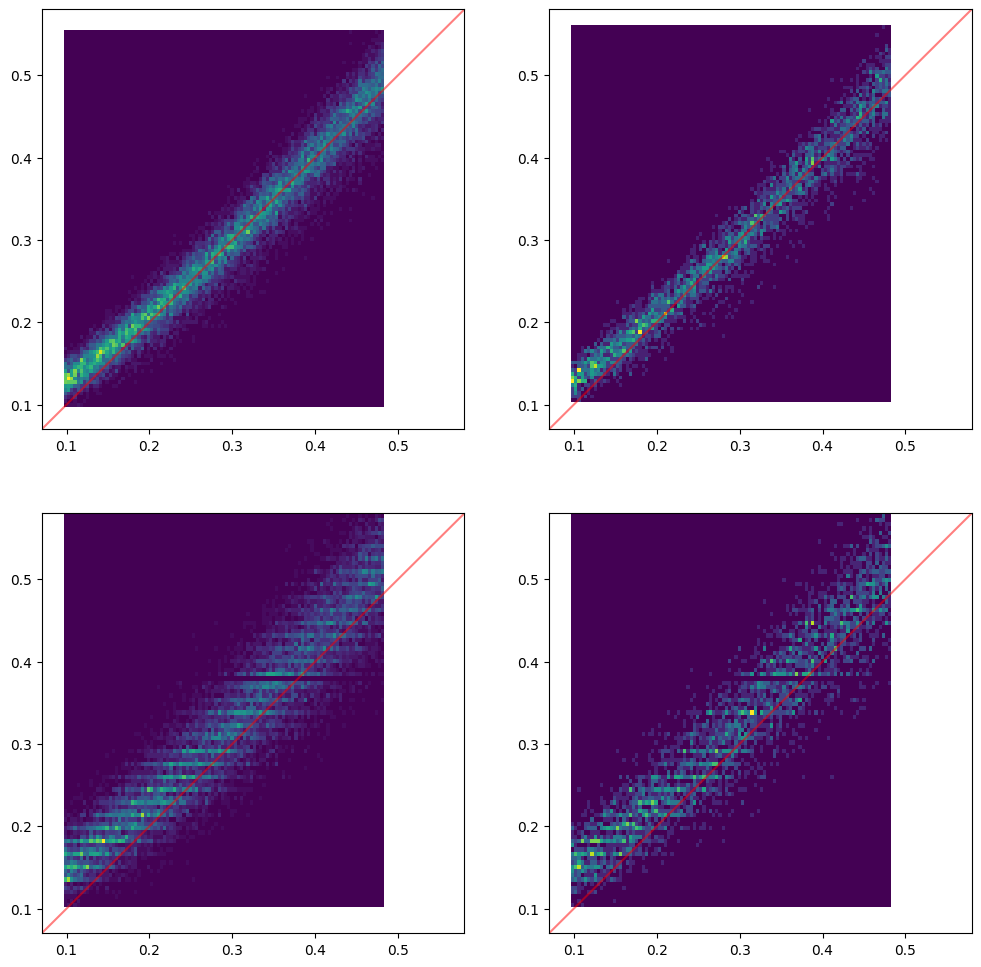

In [53]:
nbins = 100
a = 0.07; b = 0.58
for i in range(num_truths_to_use):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(12,12))
    ax1.hist2d(train_truth[:,i].ravel(), train_prediction[:,i].ravel(),     bins=nbins); ax1.plot([0.0, 1.0], [0.0, 1.0], color="red", alpha=0.5); ax1.set_xlim(a, b); ax1.set_ylim(a, b)
    ax2.hist2d(test_truth[:,i].ravel(),  test_prediction[:,i].ravel(),      bins=nbins); ax2.plot([0.0, 1.0], [0.0, 1.0], color="red", alpha=0.5); ax2.set_xlim(a, b); ax2.set_ylim(a, b)
    ax3.hist2d(train_truth[:,i].ravel(), hls_train_prediction[:,i].ravel(), bins=nbins); ax3.plot([0.0, 1.0], [0.0, 1.0], color="red", alpha=0.5); ax3.set_xlim(a, b); ax3.set_ylim(a, b)
    ax4.hist2d(test_truth[:,i].ravel(),  hls_test_prediction[:,i].ravel(),  bins=nbins); ax4.plot([0.0, 1.0], [0.0, 1.0], color="red", alpha=0.5); ax4.set_xlim(a, b); ax4.set_ylim(a, b)
    plt.show()
    fig.savefig(name + "/hist2d." + str(truths_to_use[i]) + ".png")

In [54]:
if synth_hls:
    hls_model.build(synth=True, csim=True, cosim=True)


****** Vitis HLS - High-Level Synthesis from C, C++ and OpenCL v2023.1 (64-bit)
  **** SW Build 3854077 on May  4 2023
  **** IP Build 3864474 on Sun May  7 20:36:21 MDT 2023
  **** SharedData Build 3865790 on Sun May 07 13:33:03 MDT 2023
    ** Copyright 1986-2022 Xilinx, Inc. All Rights Reserved.
    ** Copyright 2022-2023 Advanced Micro Devices, Inc. All Rights Reserved.

source /opt/Xilinx/Vitis_HLS/2023.1/scripts/vitis_hls/hls.tcl -notrace
INFO: [HLS 200-10] Running '/opt/Xilinx/Vitis_HLS/2023.1/bin/unwrapped/lnx64.o/vitis_hls'
INFO: [HLS 200-10] For user 'root' on host '17425374c219' (Linux_x86_64 version 6.11.0-21-generic) on Tue May 06 18:55:10 EDT 2025
INFO: [HLS 200-10] In directory '/root/build/phys476/final_project/waveform_dataset/mza_try5/hls4ml_prj'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-1510] Running: open_project myproject_prj 
INFO: [HLS 200-10] Opening project '/root/build/phys476/final_project/waveform_dataset/mza_try5/hls4ml_prj/myproject_prj'.
INFO: [

INFO: [HLS 200-777] Using interface defaults for 'Vivado' flow target.
INFO: [HLS 200-1995] There were 6,299 instructions in the design after the 'Compile/Link' phase of compilation. See the Design Size Report for more details: /root/build/phys476/final_project/waveform_dataset/mza_try5/hls4ml_prj/myproject_prj/solution1/syn/report/csynth_design_size.rpt
INFO: [HLS 200-1995] There were 36,835 instructions in the design after the 'Unroll/Inline' phase of compilation. See the Design Size Report for more details: /root/build/phys476/final_project/waveform_dataset/mza_try5/hls4ml_prj/myproject_prj/solution1/syn/report/csynth_design_size.rpt
INFO: [HLS 200-1995] There were 70,513 instructions in the design after the 'Performance/Pipeline' phase of compilation. See the Design Size Report for more details: /root/build/phys476/final_project/waveform_dataset/mza_try5/hls4ml_prj/myproject_prj/solution1/syn/report/csynth_design_size.rpt
INFO: [HLS 200-1995] There were 70,044 instructions in the d

INFO: [HLS 200-111] Finished Compiling Optimization and Transform: CPU user time: 112.99 seconds. CPU system time: 1.39 seconds. Elapsed time: 117.84 seconds; current allocated memory: 1.096 GB.
INFO: [HLS 200-111] Finished Checking Pragmas: CPU user time: 0 seconds. CPU system time: 0 seconds. Elapsed time: 0 seconds; current allocated memory: 1.096 GB.
INFO: [HLS 200-10] Starting code transformations ...
INFO: [HLS 200-111] Finished Standard Transforms: CPU user time: 15.03 seconds. CPU system time: 0.15 seconds. Elapsed time: 15.19 seconds; current allocated memory: 1.387 GB.
INFO: [HLS 200-10] Checking synthesizability ...
INFO: [SYNCHK 200-10] 0 error(s), 1 warning(s).
INFO: [HLS 200-111] Finished Checking Synthesizability: CPU user time: 12.38 seconds. CPU system time: 0.04 seconds. Elapsed time: 12.43 seconds; current allocated memory: 1.466 GB.
INFO: [XFORM 203-602] Inlining function 'nnet::cast<ap_fixed<9, 3, (ap_q_mode)4, (ap_o_mode)0, 0>, ap_fixed<26, 13, (ap_q_mode)5, (ap_o

INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111] Finished Binding: CPU user time: 0.49 seconds. CPU system time: 0.01 seconds. Elapsed time: 0.5 seconds; current allocated memory: 1.555 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'hard_sigmoid_ap_fixed_ap_ufixed_9_0_4_0_0_hard_sigmoid_config4_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-61] Pipelining function 'hard_sigmoid<ap_fixed,ap_ufixed<9,0,4,0,0>,hard_sigmoid_config4>'.
INFO: [HLS 200-1470] Pipelining result : Target II = NA, Final II = 1, Depth = 5, function 'hard_sigmoid<ap_fixed,ap_ufixed<9,0,4,0,0>,hard_

Resolution: For help on HLS 200-871 see www.xilinx.com/cgi-bin/docs/rdoc?v=2023.1;t=hls+guidance;d=200-871.html
	'call' operation ('call_ret3', firmware/nnet_utils/nnet_dense.h:76->firmware/nnet_utils/nnet_dense.h:45->firmware/myproject.cpp:46) to 'dense_resource_rf_gt_nin_rem0<ap_ufixed,ap_fixed<26,10,5,3,0>,config5>' [220]  (5.741 ns)

Resolution: For help on HLS 200-1016 see www.xilinx.com/cgi-bin/docs/rdoc?v=2023.1;t=hls+guidance;d=200-1016.html
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111] Finished Scheduling: CPU user time: 0.18 seconds. CPU system time: 0.01 seconds. Elapsed time: 0.19 seconds; current allocated memory: 1.555 GB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111] Finished Binding: CPU user time: 0.22 seconds. CPU s

INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'sigmoid_ap_fixed_25_9_5_3_0_ap_fixed_9_1_4_0_0_sigmoid_config10_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SYN 201-210] Renamed object name 'sigmoid_ap_fixed_25_9_5_3_0_ap_fixed_9_1_4_0_0_sigmoid_config10_s_sigmoid_table_ROM_AUTO_1R' to 'sigmoid_ap_fixed_25_9_5_3_0_ap_fixed_9_1_4_0_0_sigmoid_config10_s_sigmoid_tabg8j' due to the length limit 80
INFO: [HLS 200-1030] Apply Unified Pipeline Control on module 'sigmoid_ap_fixed_25_9_5_3_0_ap_fixed_9_1_4_0_0_sigmoid_config10_s' pipeline 'sigmoid<ap_fixed<25, 9, 5, 3, 0>, ap_fixed<9, 1, 4, 0, 0>, sigmoid_config10>' pipeline type 'function pipeline'
INFO: [RTGEN 206-100] Finished creating RTL model for 'sigmoid_ap_fixed_25_9_5_3_0_ap_fixed_9_1_4_0_0_sigmoid_config10_s'.
INFO: [RTMG 210-279] Implementing memory 'myproject_sigmoid_ap_fixed_25_9_5_3_0_ap_fixed_9_1_

INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_92_U(myproject_fifo_w16_d2_S)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_93_U(myproject_fifo_w16_d2_S)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_94_U(myproject_fifo_w16_d2_S)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_95_U(myproject_fifo_w16_d2_S)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_96_U(myproject_fifo_w16_d2_S)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_97_U(myproject_fifo_w16_d2_S)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_98_U(myproject_fifo_w16_d2_S)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_99_U(myproject_fifo_w16_d2_S)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_U(myproject_fifo_w9_d2_S)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_1_U(mypr

INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_72_U(myproject_fifo_w9_d2_S)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_73_U(myproject_fifo_w9_d2_S)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_74_U(myproject_fifo_w9_d2_S)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_75_U(myproject_fifo_w9_d2_S)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_76_U(myproject_fifo_w9_d2_S)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_77_U(myproject_fifo_w9_d2_S)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_78_U(myproject_fifo_w9_d2_S)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_79_U(myproject_fifo_w9_d2_S)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_80_U(myproject_fifo_w9_d2_S)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_81_U(myprojec

INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_43_U(myproject_fifo_w9_d2_S)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_44_U(myproject_fifo_w9_d2_S)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_45_U(myproject_fifo_w9_d2_S)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_46_U(myproject_fifo_w9_d2_S)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_47_U(myproject_fifo_w9_d2_S)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_48_U(myproject_fifo_w9_d2_S)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_49_U(myproject_fifo_w9_d2_S)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_50_U(myproject_fifo_w9_d2_S)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_51_U(myproject_fifo_w9_d2_S)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_52_U(myprojec

INFO: [VRFC 10-2263] Analyzing SystemVerilog file "/root/build/phys476/final_project/waveform_dataset/mza_try5/hls4ml_prj/myproject_prj/solution1/sim/verilog/myproject_mul_16s_7s_23_2_1.v" into library xil_defaultlib
INFO: [VRFC 10-311] analyzing module myproject_mul_16s_7s_23_2_1
INFO: [VRFC 10-2263] Analyzing SystemVerilog file "/root/build/phys476/final_project/waveform_dataset/mza_try5/hls4ml_prj/myproject_prj/solution1/sim/verilog/myproject_mul_16s_12s_27_2_1.v" into library xil_defaultlib
INFO: [VRFC 10-311] analyzing module myproject_mul_16s_12s_27_2_1
INFO: [VRFC 10-2263] Analyzing SystemVerilog file "/root/build/phys476/final_project/waveform_dataset/mza_try5/hls4ml_prj/myproject_prj/solution1/sim/verilog/myproject_mul_16s_11s_26_2_1.v" into library xil_defaultlib
INFO: [VRFC 10-311] analyzing module myproject_mul_16s_11s_26_2_1
INFO: [VRFC 10-2263] Analyzing SystemVerilog file "/root/build/phys476/final_project/waveform_dataset/mza_try5/hls4ml_prj/myproject_prj/solution1/sim/

Starting static elaboration
Pass Through NonSizing Optimizer
Completed static elaboration


Starting simulation data flow analysis
Completed simulation data flow analysis
Time Resolution for simulation is 1ps
Compiling package xil_defaultlib.$unit_dataflow_monitor_sv
Compiling module xil_defaultlib.myproject_dense_resource_rf_gt_n...
Compiling module xil_defaultlib.myproject_dense_resource_rf_gt_n...
Compiling module xil_defaultlib.myproject_lshr_900ns_10ns_900_7_...
Compiling module xil_defaultlib.myproject_mul_9s_9s_18_3_1(NUM_S...
Compiling module xil_defaultlib.myproject_mul_9s_6s_15_3_1(NUM_S...
Compiling module xil_defaultlib.myproject_flow_control_loop_pipe
Compiling module xil_defaultlib.myproject_frp_pipeline_valid(Pip...
Compiling module xil_defaultlib.myproject_frp_fifoout(BlockingTy...
Compiling module xil_defaultlib.myproject_dense_resource_rf_gt_n...
Compiling module xil_defaultlib.myproject_frp_pipeline_valid(Pip...
Compiling module xil_defaultlib.myproject_frp_fifoout(BlockingTy...
Compiling module xil_defaultlib.myproject_hard_sigmoid_ap_fixed_...
Compiling m

// RTL Simulation : 1 / 4000 [60.24%] @ "2623000"
// RTL Simulation : 2 / 4000 [60.24%] @ "3623000"
// RTL Simulation : 3 / 4000 [60.24%] @ "4623000"
// RTL Simulation : 4 / 4000 [60.24%] @ "5623000"
// RTL Simulation : 5 / 4000 [60.24%] @ "6623000"
// RTL Simulation : 6 / 4000 [60.24%] @ "7623000"
// RTL Simulation : 7 / 4000 [60.24%] @ "8623000"
// RTL Simulation : 8 / 4000 [60.24%] @ "9623000"
// RTL Simulation : 9 / 4000 [60.24%] @ "10623000"
// RTL Simulation : 10 / 4000 [60.24%] @ "11623000"
// RTL Simulation : 11 / 4000 [60.24%] @ "12623000"
// RTL Simulation : 12 / 4000 [60.24%] @ "13623000"
// RTL Simulation : 13 / 4000 [60.24%] @ "14623000"
// RTL Simulation : 14 / 4000 [60.24%] @ "15623000"
// RTL Simulation : 15 / 4000 [60.24%] @ "16623000"
// RTL Simulation : 16 / 4000 [60.24%] @ "17623000"
// RTL Simulation : 17 / 4000 [60.24%] @ "18623000"
// RTL Simulation : 18 / 4000 [60.24%] @ "19623000"
// RTL Simulation : 19 / 4000 [60.24%] @ "20623000"
// RTL Simulation : 20 / 4000

// RTL Simulation : 157 / 4000 [60.24%] @ "158623000"
// RTL Simulation : 158 / 4000 [60.24%] @ "159623000"
// RTL Simulation : 159 / 4000 [60.24%] @ "160623000"
// RTL Simulation : 160 / 4000 [60.24%] @ "161623000"
// RTL Simulation : 161 / 4000 [60.24%] @ "162623000"
// RTL Simulation : 162 / 4000 [60.24%] @ "163623000"
// RTL Simulation : 163 / 4000 [60.24%] @ "164623000"
// RTL Simulation : 164 / 4000 [60.24%] @ "165623000"
// RTL Simulation : 165 / 4000 [60.24%] @ "166623000"
// RTL Simulation : 166 / 4000 [60.24%] @ "167623000"
// RTL Simulation : 167 / 4000 [60.24%] @ "168623000"
// RTL Simulation : 168 / 4000 [60.24%] @ "169623000"
// RTL Simulation : 169 / 4000 [60.24%] @ "170623000"
// RTL Simulation : 170 / 4000 [60.24%] @ "171623000"
// RTL Simulation : 171 / 4000 [60.24%] @ "172623000"
// RTL Simulation : 172 / 4000 [60.24%] @ "173623000"
// RTL Simulation : 173 / 4000 [60.24%] @ "174623000"
// RTL Simulation : 174 / 4000 [60.24%] @ "175623000"
// RTL Simulation : 175 / 40

// RTL Simulation : 309 / 4000 [60.24%] @ "310623000"
// RTL Simulation : 310 / 4000 [60.24%] @ "311623000"
// RTL Simulation : 311 / 4000 [60.24%] @ "312623000"
// RTL Simulation : 312 / 4000 [60.24%] @ "313623000"
// RTL Simulation : 313 / 4000 [60.24%] @ "314623000"
// RTL Simulation : 314 / 4000 [60.24%] @ "315623000"
// RTL Simulation : 315 / 4000 [60.24%] @ "316623000"
// RTL Simulation : 316 / 4000 [60.24%] @ "317623000"
// RTL Simulation : 317 / 4000 [60.24%] @ "318623000"
// RTL Simulation : 318 / 4000 [60.24%] @ "319623000"
// RTL Simulation : 319 / 4000 [60.24%] @ "320623000"
// RTL Simulation : 320 / 4000 [60.24%] @ "321623000"
// RTL Simulation : 321 / 4000 [60.24%] @ "322623000"
// RTL Simulation : 322 / 4000 [60.24%] @ "323623000"
// RTL Simulation : 323 / 4000 [60.24%] @ "324623000"
// RTL Simulation : 324 / 4000 [60.24%] @ "325623000"
// RTL Simulation : 325 / 4000 [60.24%] @ "326623000"
// RTL Simulation : 326 / 4000 [60.24%] @ "327623000"
// RTL Simulation : 327 / 40

// RTL Simulation : 461 / 4000 [60.24%] @ "462623000"
// RTL Simulation : 462 / 4000 [60.24%] @ "463623000"
// RTL Simulation : 463 / 4000 [60.24%] @ "464623000"
// RTL Simulation : 464 / 4000 [60.24%] @ "465623000"
// RTL Simulation : 465 / 4000 [60.24%] @ "466623000"
// RTL Simulation : 466 / 4000 [60.24%] @ "467623000"
// RTL Simulation : 467 / 4000 [60.24%] @ "468623000"
// RTL Simulation : 468 / 4000 [60.24%] @ "469623000"
// RTL Simulation : 469 / 4000 [60.24%] @ "470623000"
// RTL Simulation : 470 / 4000 [60.24%] @ "471623000"
// RTL Simulation : 471 / 4000 [60.24%] @ "472623000"
// RTL Simulation : 472 / 4000 [60.24%] @ "473623000"
// RTL Simulation : 473 / 4000 [60.24%] @ "474623000"
// RTL Simulation : 474 / 4000 [60.24%] @ "475623000"
// RTL Simulation : 475 / 4000 [60.24%] @ "476623000"
// RTL Simulation : 476 / 4000 [60.24%] @ "477623000"
// RTL Simulation : 477 / 4000 [60.24%] @ "478623000"
// RTL Simulation : 478 / 4000 [60.24%] @ "479623000"
// RTL Simulation : 479 / 40

// RTL Simulation : 613 / 4000 [60.24%] @ "614623000"
// RTL Simulation : 614 / 4000 [60.24%] @ "615623000"
// RTL Simulation : 615 / 4000 [60.24%] @ "616623000"
// RTL Simulation : 616 / 4000 [60.24%] @ "617623000"
// RTL Simulation : 617 / 4000 [60.24%] @ "618623000"
// RTL Simulation : 618 / 4000 [60.24%] @ "619623000"
// RTL Simulation : 619 / 4000 [60.24%] @ "620623000"
// RTL Simulation : 620 / 4000 [60.24%] @ "621623000"
// RTL Simulation : 621 / 4000 [60.24%] @ "622623000"
// RTL Simulation : 622 / 4000 [60.24%] @ "623623000"
// RTL Simulation : 623 / 4000 [60.24%] @ "624623000"
// RTL Simulation : 624 / 4000 [60.24%] @ "625623000"
// RTL Simulation : 625 / 4000 [60.24%] @ "626623000"
// RTL Simulation : 626 / 4000 [60.24%] @ "627623000"
// RTL Simulation : 627 / 4000 [60.24%] @ "628623000"
// RTL Simulation : 628 / 4000 [60.24%] @ "629623000"
// RTL Simulation : 629 / 4000 [60.24%] @ "630623000"
// RTL Simulation : 630 / 4000 [60.24%] @ "631623000"
// RTL Simulation : 631 / 40

// RTL Simulation : 765 / 4000 [60.24%] @ "766623000"
// RTL Simulation : 766 / 4000 [60.24%] @ "767623000"
// RTL Simulation : 767 / 4000 [60.24%] @ "768623000"
// RTL Simulation : 768 / 4000 [60.24%] @ "769623000"
// RTL Simulation : 769 / 4000 [60.24%] @ "770623000"
// RTL Simulation : 770 / 4000 [60.24%] @ "771623000"
// RTL Simulation : 771 / 4000 [60.24%] @ "772623000"
// RTL Simulation : 772 / 4000 [60.24%] @ "773623000"
// RTL Simulation : 773 / 4000 [60.24%] @ "774623000"
// RTL Simulation : 774 / 4000 [60.24%] @ "775623000"
// RTL Simulation : 775 / 4000 [60.24%] @ "776623000"
// RTL Simulation : 776 / 4000 [60.24%] @ "777623000"
// RTL Simulation : 777 / 4000 [60.24%] @ "778623000"
// RTL Simulation : 778 / 4000 [60.24%] @ "779623000"
// RTL Simulation : 779 / 4000 [60.24%] @ "780623000"
// RTL Simulation : 780 / 4000 [60.24%] @ "781623000"
// RTL Simulation : 781 / 4000 [60.24%] @ "782623000"
// RTL Simulation : 782 / 4000 [60.24%] @ "783623000"
// RTL Simulation : 783 / 40

// RTL Simulation : 917 / 4000 [60.24%] @ "918623000"
// RTL Simulation : 918 / 4000 [60.24%] @ "919623000"
// RTL Simulation : 919 / 4000 [60.24%] @ "920623000"
// RTL Simulation : 920 / 4000 [60.24%] @ "921623000"
// RTL Simulation : 921 / 4000 [60.24%] @ "922623000"
// RTL Simulation : 922 / 4000 [60.24%] @ "923623000"
// RTL Simulation : 923 / 4000 [60.24%] @ "924623000"
// RTL Simulation : 924 / 4000 [60.24%] @ "925623000"
// RTL Simulation : 925 / 4000 [60.24%] @ "926623000"
// RTL Simulation : 926 / 4000 [60.24%] @ "927623000"
// RTL Simulation : 927 / 4000 [60.24%] @ "928623000"
// RTL Simulation : 928 / 4000 [60.24%] @ "929623000"
// RTL Simulation : 929 / 4000 [60.24%] @ "930623000"
// RTL Simulation : 930 / 4000 [60.24%] @ "931623000"
// RTL Simulation : 931 / 4000 [60.24%] @ "932623000"
// RTL Simulation : 932 / 4000 [60.24%] @ "933623000"
// RTL Simulation : 933 / 4000 [60.24%] @ "934623000"
// RTL Simulation : 934 / 4000 [60.24%] @ "935623000"
// RTL Simulation : 935 / 40

// RTL Simulation : 1067 / 4000 [60.24%] @ "1068623000"
// RTL Simulation : 1068 / 4000 [60.24%] @ "1069623000"
// RTL Simulation : 1069 / 4000 [60.24%] @ "1070623000"
// RTL Simulation : 1070 / 4000 [60.24%] @ "1071623000"
// RTL Simulation : 1071 / 4000 [60.24%] @ "1072623000"
// RTL Simulation : 1072 / 4000 [60.24%] @ "1073623000"
// RTL Simulation : 1073 / 4000 [60.24%] @ "1074623000"
// RTL Simulation : 1074 / 4000 [60.24%] @ "1075623000"
// RTL Simulation : 1075 / 4000 [60.24%] @ "1076623000"
// RTL Simulation : 1076 / 4000 [60.24%] @ "1077623000"
// RTL Simulation : 1077 / 4000 [60.24%] @ "1078623000"
// RTL Simulation : 1078 / 4000 [60.24%] @ "1079623000"
// RTL Simulation : 1079 / 4000 [60.24%] @ "1080623000"
// RTL Simulation : 1080 / 4000 [60.24%] @ "1081623000"
// RTL Simulation : 1081 / 4000 [60.24%] @ "1082623000"
// RTL Simulation : 1082 / 4000 [60.24%] @ "1083623000"
// RTL Simulation : 1083 / 4000 [60.24%] @ "1084623000"
// RTL Simulation : 1084 / 4000 [60.24%] @ "1085

// RTL Simulation : 1215 / 4000 [60.24%] @ "1216623000"
// RTL Simulation : 1216 / 4000 [60.24%] @ "1217623000"
// RTL Simulation : 1217 / 4000 [60.24%] @ "1218623000"
// RTL Simulation : 1218 / 4000 [60.24%] @ "1219623000"
// RTL Simulation : 1219 / 4000 [60.24%] @ "1220623000"
// RTL Simulation : 1220 / 4000 [60.24%] @ "1221623000"
// RTL Simulation : 1221 / 4000 [60.24%] @ "1222623000"
// RTL Simulation : 1222 / 4000 [60.24%] @ "1223623000"
// RTL Simulation : 1223 / 4000 [60.24%] @ "1224623000"
// RTL Simulation : 1224 / 4000 [60.24%] @ "1225623000"
// RTL Simulation : 1225 / 4000 [60.24%] @ "1226623000"
// RTL Simulation : 1226 / 4000 [60.24%] @ "1227623000"
// RTL Simulation : 1227 / 4000 [60.24%] @ "1228623000"
// RTL Simulation : 1228 / 4000 [60.24%] @ "1229623000"
// RTL Simulation : 1229 / 4000 [60.24%] @ "1230623000"
// RTL Simulation : 1230 / 4000 [60.24%] @ "1231623000"
// RTL Simulation : 1231 / 4000 [60.24%] @ "1232623000"
// RTL Simulation : 1232 / 4000 [60.24%] @ "1233

// RTL Simulation : 1363 / 4000 [60.24%] @ "1364623000"
// RTL Simulation : 1364 / 4000 [60.24%] @ "1365623000"
// RTL Simulation : 1365 / 4000 [60.24%] @ "1366623000"
// RTL Simulation : 1366 / 4000 [60.24%] @ "1367623000"
// RTL Simulation : 1367 / 4000 [60.24%] @ "1368623000"
// RTL Simulation : 1368 / 4000 [60.24%] @ "1369623000"
// RTL Simulation : 1369 / 4000 [60.24%] @ "1370623000"
// RTL Simulation : 1370 / 4000 [60.24%] @ "1371623000"
// RTL Simulation : 1371 / 4000 [60.24%] @ "1372623000"
// RTL Simulation : 1372 / 4000 [60.24%] @ "1373623000"
// RTL Simulation : 1373 / 4000 [60.24%] @ "1374623000"
// RTL Simulation : 1374 / 4000 [60.24%] @ "1375623000"
// RTL Simulation : 1375 / 4000 [60.24%] @ "1376623000"
// RTL Simulation : 1376 / 4000 [60.24%] @ "1377623000"
// RTL Simulation : 1377 / 4000 [60.24%] @ "1378623000"
// RTL Simulation : 1378 / 4000 [60.24%] @ "1379623000"
// RTL Simulation : 1379 / 4000 [60.24%] @ "1380623000"
// RTL Simulation : 1380 / 4000 [60.24%] @ "1381

// RTL Simulation : 1511 / 4000 [60.24%] @ "1512623000"
// RTL Simulation : 1512 / 4000 [60.24%] @ "1513623000"
// RTL Simulation : 1513 / 4000 [60.24%] @ "1514623000"
// RTL Simulation : 1514 / 4000 [60.24%] @ "1515623000"
// RTL Simulation : 1515 / 4000 [60.24%] @ "1516623000"
// RTL Simulation : 1516 / 4000 [60.24%] @ "1517623000"
// RTL Simulation : 1517 / 4000 [60.24%] @ "1518623000"
// RTL Simulation : 1518 / 4000 [60.24%] @ "1519623000"
// RTL Simulation : 1519 / 4000 [60.24%] @ "1520623000"
// RTL Simulation : 1520 / 4000 [60.24%] @ "1521623000"
// RTL Simulation : 1521 / 4000 [60.24%] @ "1522623000"
// RTL Simulation : 1522 / 4000 [60.24%] @ "1523623000"
// RTL Simulation : 1523 / 4000 [60.24%] @ "1524623000"
// RTL Simulation : 1524 / 4000 [60.24%] @ "1525623000"
// RTL Simulation : 1525 / 4000 [60.24%] @ "1526623000"
// RTL Simulation : 1526 / 4000 [60.24%] @ "1527623000"
// RTL Simulation : 1527 / 4000 [60.24%] @ "1528623000"
// RTL Simulation : 1528 / 4000 [60.24%] @ "1529

// RTL Simulation : 1659 / 4000 [60.24%] @ "1660623000"
// RTL Simulation : 1660 / 4000 [60.24%] @ "1661623000"
// RTL Simulation : 1661 / 4000 [60.24%] @ "1662623000"
// RTL Simulation : 1662 / 4000 [60.24%] @ "1663623000"
// RTL Simulation : 1663 / 4000 [60.24%] @ "1664623000"
// RTL Simulation : 1664 / 4000 [60.24%] @ "1665623000"
// RTL Simulation : 1665 / 4000 [60.24%] @ "1666623000"
// RTL Simulation : 1666 / 4000 [60.24%] @ "1667623000"
// RTL Simulation : 1667 / 4000 [60.24%] @ "1668623000"
// RTL Simulation : 1668 / 4000 [60.24%] @ "1669623000"
// RTL Simulation : 1669 / 4000 [60.24%] @ "1670623000"
// RTL Simulation : 1670 / 4000 [60.24%] @ "1671623000"
// RTL Simulation : 1671 / 4000 [60.24%] @ "1672623000"
// RTL Simulation : 1672 / 4000 [60.24%] @ "1673623000"
// RTL Simulation : 1673 / 4000 [60.24%] @ "1674623000"
// RTL Simulation : 1674 / 4000 [60.24%] @ "1675623000"
// RTL Simulation : 1675 / 4000 [60.24%] @ "1676623000"
// RTL Simulation : 1676 / 4000 [60.24%] @ "1677

// RTL Simulation : 1807 / 4000 [60.24%] @ "1808623000"
// RTL Simulation : 1808 / 4000 [60.24%] @ "1809623000"
// RTL Simulation : 1809 / 4000 [60.24%] @ "1810623000"
// RTL Simulation : 1810 / 4000 [60.24%] @ "1811623000"
// RTL Simulation : 1811 / 4000 [60.24%] @ "1812623000"
// RTL Simulation : 1812 / 4000 [60.24%] @ "1813623000"
// RTL Simulation : 1813 / 4000 [60.24%] @ "1814623000"
// RTL Simulation : 1814 / 4000 [60.24%] @ "1815623000"
// RTL Simulation : 1815 / 4000 [60.24%] @ "1816623000"
// RTL Simulation : 1816 / 4000 [60.24%] @ "1817623000"
// RTL Simulation : 1817 / 4000 [60.24%] @ "1818623000"
// RTL Simulation : 1818 / 4000 [60.24%] @ "1819623000"
// RTL Simulation : 1819 / 4000 [60.24%] @ "1820623000"
// RTL Simulation : 1820 / 4000 [60.24%] @ "1821623000"
// RTL Simulation : 1821 / 4000 [60.24%] @ "1822623000"
// RTL Simulation : 1822 / 4000 [60.24%] @ "1823623000"
// RTL Simulation : 1823 / 4000 [60.24%] @ "1824623000"
// RTL Simulation : 1824 / 4000 [60.24%] @ "1825

// RTL Simulation : 1955 / 4000 [60.24%] @ "1956623000"
// RTL Simulation : 1956 / 4000 [60.24%] @ "1957623000"
// RTL Simulation : 1957 / 4000 [60.24%] @ "1958623000"
// RTL Simulation : 1958 / 4000 [60.24%] @ "1959623000"
// RTL Simulation : 1959 / 4000 [60.24%] @ "1960623000"
// RTL Simulation : 1960 / 4000 [60.24%] @ "1961623000"
// RTL Simulation : 1961 / 4000 [60.24%] @ "1962623000"
// RTL Simulation : 1962 / 4000 [60.24%] @ "1963623000"
// RTL Simulation : 1963 / 4000 [60.24%] @ "1964623000"
// RTL Simulation : 1964 / 4000 [60.24%] @ "1965623000"
// RTL Simulation : 1965 / 4000 [60.24%] @ "1966623000"
// RTL Simulation : 1966 / 4000 [60.24%] @ "1967623000"
// RTL Simulation : 1967 / 4000 [60.24%] @ "1968623000"
// RTL Simulation : 1968 / 4000 [60.24%] @ "1969623000"
// RTL Simulation : 1969 / 4000 [60.24%] @ "1970623000"
// RTL Simulation : 1970 / 4000 [60.24%] @ "1971623000"
// RTL Simulation : 1971 / 4000 [60.24%] @ "1972623000"
// RTL Simulation : 1972 / 4000 [60.24%] @ "1973

// RTL Simulation : 2103 / 4000 [60.24%] @ "2104623000"
// RTL Simulation : 2104 / 4000 [60.24%] @ "2105623000"
// RTL Simulation : 2105 / 4000 [60.24%] @ "2106623000"
// RTL Simulation : 2106 / 4000 [60.24%] @ "2107623000"
// RTL Simulation : 2107 / 4000 [60.24%] @ "2108623000"
// RTL Simulation : 2108 / 4000 [60.24%] @ "2109623000"
// RTL Simulation : 2109 / 4000 [60.24%] @ "2110623000"
// RTL Simulation : 2110 / 4000 [60.24%] @ "2111623000"
// RTL Simulation : 2111 / 4000 [60.24%] @ "2112623000"
// RTL Simulation : 2112 / 4000 [60.24%] @ "2113623000"
// RTL Simulation : 2113 / 4000 [60.24%] @ "2114623000"
// RTL Simulation : 2114 / 4000 [60.24%] @ "2115623000"
// RTL Simulation : 2115 / 4000 [60.24%] @ "2116623000"
// RTL Simulation : 2116 / 4000 [60.24%] @ "2117623000"
// RTL Simulation : 2117 / 4000 [60.24%] @ "2118623000"
// RTL Simulation : 2118 / 4000 [60.24%] @ "2119623000"
// RTL Simulation : 2119 / 4000 [60.24%] @ "2120623000"
// RTL Simulation : 2120 / 4000 [60.24%] @ "2121

// RTL Simulation : 2251 / 4000 [60.24%] @ "2252623000"
// RTL Simulation : 2252 / 4000 [60.24%] @ "2253623000"
// RTL Simulation : 2253 / 4000 [60.24%] @ "2254623000"
// RTL Simulation : 2254 / 4000 [60.24%] @ "2255623000"
// RTL Simulation : 2255 / 4000 [60.24%] @ "2256623000"
// RTL Simulation : 2256 / 4000 [60.24%] @ "2257623000"
// RTL Simulation : 2257 / 4000 [60.24%] @ "2258623000"
// RTL Simulation : 2258 / 4000 [60.24%] @ "2259623000"
// RTL Simulation : 2259 / 4000 [60.24%] @ "2260623000"
// RTL Simulation : 2260 / 4000 [60.24%] @ "2261623000"
// RTL Simulation : 2261 / 4000 [60.24%] @ "2262623000"
// RTL Simulation : 2262 / 4000 [60.24%] @ "2263623000"
// RTL Simulation : 2263 / 4000 [60.24%] @ "2264623000"
// RTL Simulation : 2264 / 4000 [60.24%] @ "2265623000"
// RTL Simulation : 2265 / 4000 [60.24%] @ "2266623000"
// RTL Simulation : 2266 / 4000 [60.24%] @ "2267623000"
// RTL Simulation : 2267 / 4000 [60.24%] @ "2268623000"
// RTL Simulation : 2268 / 4000 [60.24%] @ "2269

// RTL Simulation : 2399 / 4000 [60.24%] @ "2400623000"
// RTL Simulation : 2400 / 4000 [60.24%] @ "2401623000"
// RTL Simulation : 2401 / 4000 [60.24%] @ "2402623000"
// RTL Simulation : 2402 / 4000 [60.24%] @ "2403623000"
// RTL Simulation : 2403 / 4000 [60.24%] @ "2404623000"
// RTL Simulation : 2404 / 4000 [60.24%] @ "2405623000"
// RTL Simulation : 2405 / 4000 [60.24%] @ "2406623000"
// RTL Simulation : 2406 / 4000 [60.24%] @ "2407623000"
// RTL Simulation : 2407 / 4000 [60.24%] @ "2408623000"
// RTL Simulation : 2408 / 4000 [60.24%] @ "2409623000"
// RTL Simulation : 2409 / 4000 [60.24%] @ "2410623000"
// RTL Simulation : 2410 / 4000 [60.24%] @ "2411623000"
// RTL Simulation : 2411 / 4000 [60.24%] @ "2412623000"
// RTL Simulation : 2412 / 4000 [60.24%] @ "2413623000"
// RTL Simulation : 2413 / 4000 [60.24%] @ "2414623000"
// RTL Simulation : 2414 / 4000 [60.24%] @ "2415623000"
// RTL Simulation : 2415 / 4000 [60.24%] @ "2416623000"
// RTL Simulation : 2416 / 4000 [60.24%] @ "2417

// RTL Simulation : 2547 / 4000 [60.24%] @ "2548623000"
// RTL Simulation : 2548 / 4000 [60.24%] @ "2549623000"
// RTL Simulation : 2549 / 4000 [60.24%] @ "2550623000"
// RTL Simulation : 2550 / 4000 [60.24%] @ "2551623000"
// RTL Simulation : 2551 / 4000 [60.24%] @ "2552623000"
// RTL Simulation : 2552 / 4000 [60.24%] @ "2553623000"
// RTL Simulation : 2553 / 4000 [60.24%] @ "2554623000"
// RTL Simulation : 2554 / 4000 [60.24%] @ "2555623000"
// RTL Simulation : 2555 / 4000 [60.24%] @ "2556623000"
// RTL Simulation : 2556 / 4000 [60.24%] @ "2557623000"
// RTL Simulation : 2557 / 4000 [60.24%] @ "2558623000"
// RTL Simulation : 2558 / 4000 [60.24%] @ "2559623000"
// RTL Simulation : 2559 / 4000 [60.24%] @ "2560623000"
// RTL Simulation : 2560 / 4000 [60.24%] @ "2561623000"
// RTL Simulation : 2561 / 4000 [60.24%] @ "2562623000"
// RTL Simulation : 2562 / 4000 [60.24%] @ "2563623000"
// RTL Simulation : 2563 / 4000 [60.24%] @ "2564623000"
// RTL Simulation : 2564 / 4000 [60.24%] @ "2565

// RTL Simulation : 2695 / 4000 [60.24%] @ "2696623000"
// RTL Simulation : 2696 / 4000 [60.24%] @ "2697623000"
// RTL Simulation : 2697 / 4000 [60.24%] @ "2698623000"
// RTL Simulation : 2698 / 4000 [60.24%] @ "2699623000"
// RTL Simulation : 2699 / 4000 [60.24%] @ "2700623000"
// RTL Simulation : 2700 / 4000 [60.24%] @ "2701623000"
// RTL Simulation : 2701 / 4000 [60.24%] @ "2702623000"
// RTL Simulation : 2702 / 4000 [60.24%] @ "2703623000"
// RTL Simulation : 2703 / 4000 [60.24%] @ "2704623000"
// RTL Simulation : 2704 / 4000 [60.24%] @ "2705623000"
// RTL Simulation : 2705 / 4000 [60.24%] @ "2706623000"
// RTL Simulation : 2706 / 4000 [60.24%] @ "2707623000"
// RTL Simulation : 2707 / 4000 [60.24%] @ "2708623000"
// RTL Simulation : 2708 / 4000 [60.24%] @ "2709623000"
// RTL Simulation : 2709 / 4000 [60.24%] @ "2710623000"
// RTL Simulation : 2710 / 4000 [60.24%] @ "2711623000"
// RTL Simulation : 2711 / 4000 [60.24%] @ "2712623000"
// RTL Simulation : 2712 / 4000 [60.24%] @ "2713

// RTL Simulation : 2843 / 4000 [60.24%] @ "2844623000"
// RTL Simulation : 2844 / 4000 [60.24%] @ "2845623000"
// RTL Simulation : 2845 / 4000 [60.24%] @ "2846623000"
// RTL Simulation : 2846 / 4000 [60.24%] @ "2847623000"
// RTL Simulation : 2847 / 4000 [60.24%] @ "2848623000"
// RTL Simulation : 2848 / 4000 [60.24%] @ "2849623000"
// RTL Simulation : 2849 / 4000 [60.24%] @ "2850623000"
// RTL Simulation : 2850 / 4000 [60.24%] @ "2851623000"
// RTL Simulation : 2851 / 4000 [60.24%] @ "2852623000"
// RTL Simulation : 2852 / 4000 [60.24%] @ "2853623000"
// RTL Simulation : 2853 / 4000 [60.24%] @ "2854623000"
// RTL Simulation : 2854 / 4000 [60.24%] @ "2855623000"
// RTL Simulation : 2855 / 4000 [60.24%] @ "2856623000"
// RTL Simulation : 2856 / 4000 [60.24%] @ "2857623000"
// RTL Simulation : 2857 / 4000 [60.24%] @ "2858623000"
// RTL Simulation : 2858 / 4000 [60.24%] @ "2859623000"
// RTL Simulation : 2859 / 4000 [60.24%] @ "2860623000"
// RTL Simulation : 2860 / 4000 [60.24%] @ "2861

// RTL Simulation : 2991 / 4000 [60.24%] @ "2992623000"
// RTL Simulation : 2992 / 4000 [60.24%] @ "2993623000"
// RTL Simulation : 2993 / 4000 [60.24%] @ "2994623000"
// RTL Simulation : 2994 / 4000 [60.24%] @ "2995623000"
// RTL Simulation : 2995 / 4000 [60.24%] @ "2996623000"
// RTL Simulation : 2996 / 4000 [60.24%] @ "2997623000"
// RTL Simulation : 2997 / 4000 [60.24%] @ "2998623000"
// RTL Simulation : 2998 / 4000 [60.24%] @ "2999623000"
// RTL Simulation : 2999 / 4000 [60.24%] @ "3000623000"
// RTL Simulation : 3000 / 4000 [60.24%] @ "3001623000"
// RTL Simulation : 3001 / 4000 [60.24%] @ "3002623000"
// RTL Simulation : 3002 / 4000 [60.24%] @ "3003623000"
// RTL Simulation : 3003 / 4000 [60.24%] @ "3004623000"
// RTL Simulation : 3004 / 4000 [60.24%] @ "3005623000"
// RTL Simulation : 3005 / 4000 [60.24%] @ "3006623000"
// RTL Simulation : 3006 / 4000 [60.24%] @ "3007623000"
// RTL Simulation : 3007 / 4000 [60.24%] @ "3008623000"
// RTL Simulation : 3008 / 4000 [60.24%] @ "3009

// RTL Simulation : 3139 / 4000 [60.24%] @ "3140623000"
// RTL Simulation : 3140 / 4000 [60.24%] @ "3141623000"
// RTL Simulation : 3141 / 4000 [60.24%] @ "3142623000"
// RTL Simulation : 3142 / 4000 [60.24%] @ "3143623000"
// RTL Simulation : 3143 / 4000 [60.24%] @ "3144623000"
// RTL Simulation : 3144 / 4000 [60.24%] @ "3145623000"
// RTL Simulation : 3145 / 4000 [60.24%] @ "3146623000"
// RTL Simulation : 3146 / 4000 [60.24%] @ "3147623000"
// RTL Simulation : 3147 / 4000 [60.24%] @ "3148623000"
// RTL Simulation : 3148 / 4000 [60.24%] @ "3149623000"
// RTL Simulation : 3149 / 4000 [60.24%] @ "3150623000"
// RTL Simulation : 3150 / 4000 [60.24%] @ "3151623000"
// RTL Simulation : 3151 / 4000 [60.24%] @ "3152623000"
// RTL Simulation : 3152 / 4000 [60.24%] @ "3153623000"
// RTL Simulation : 3153 / 4000 [60.24%] @ "3154623000"
// RTL Simulation : 3154 / 4000 [60.24%] @ "3155623000"
// RTL Simulation : 3155 / 4000 [60.24%] @ "3156623000"
// RTL Simulation : 3156 / 4000 [60.24%] @ "3157

// RTL Simulation : 3287 / 4000 [60.24%] @ "3288623000"
// RTL Simulation : 3288 / 4000 [60.24%] @ "3289623000"
// RTL Simulation : 3289 / 4000 [60.24%] @ "3290623000"
// RTL Simulation : 3290 / 4000 [60.24%] @ "3291623000"
// RTL Simulation : 3291 / 4000 [60.24%] @ "3292623000"
// RTL Simulation : 3292 / 4000 [60.24%] @ "3293623000"
// RTL Simulation : 3293 / 4000 [60.24%] @ "3294623000"
// RTL Simulation : 3294 / 4000 [60.24%] @ "3295623000"
// RTL Simulation : 3295 / 4000 [60.24%] @ "3296623000"
// RTL Simulation : 3296 / 4000 [60.24%] @ "3297623000"
// RTL Simulation : 3297 / 4000 [60.24%] @ "3298623000"
// RTL Simulation : 3298 / 4000 [60.24%] @ "3299623000"
// RTL Simulation : 3299 / 4000 [60.24%] @ "3300623000"
// RTL Simulation : 3300 / 4000 [60.24%] @ "3301623000"
// RTL Simulation : 3301 / 4000 [60.24%] @ "3302623000"
// RTL Simulation : 3302 / 4000 [60.24%] @ "3303623000"
// RTL Simulation : 3303 / 4000 [60.24%] @ "3304623000"
// RTL Simulation : 3304 / 4000 [60.24%] @ "3305

// RTL Simulation : 3435 / 4000 [60.24%] @ "3436623000"
// RTL Simulation : 3436 / 4000 [60.24%] @ "3437623000"
// RTL Simulation : 3437 / 4000 [60.24%] @ "3438623000"
// RTL Simulation : 3438 / 4000 [60.24%] @ "3439623000"
// RTL Simulation : 3439 / 4000 [60.24%] @ "3440623000"
// RTL Simulation : 3440 / 4000 [60.24%] @ "3441623000"
// RTL Simulation : 3441 / 4000 [60.24%] @ "3442623000"
// RTL Simulation : 3442 / 4000 [60.24%] @ "3443623000"
// RTL Simulation : 3443 / 4000 [60.24%] @ "3444623000"
// RTL Simulation : 3444 / 4000 [60.24%] @ "3445623000"
// RTL Simulation : 3445 / 4000 [60.24%] @ "3446623000"
// RTL Simulation : 3446 / 4000 [60.24%] @ "3447623000"
// RTL Simulation : 3447 / 4000 [60.24%] @ "3448623000"
// RTL Simulation : 3448 / 4000 [60.24%] @ "3449623000"
// RTL Simulation : 3449 / 4000 [60.24%] @ "3450623000"
// RTL Simulation : 3450 / 4000 [60.24%] @ "3451623000"
// RTL Simulation : 3451 / 4000 [60.24%] @ "3452623000"
// RTL Simulation : 3452 / 4000 [60.24%] @ "3453

// RTL Simulation : 3583 / 4000 [60.24%] @ "3584623000"
// RTL Simulation : 3584 / 4000 [60.24%] @ "3585623000"
// RTL Simulation : 3585 / 4000 [60.24%] @ "3586623000"
// RTL Simulation : 3586 / 4000 [60.24%] @ "3587623000"
// RTL Simulation : 3587 / 4000 [60.24%] @ "3588623000"
// RTL Simulation : 3588 / 4000 [60.24%] @ "3589623000"
// RTL Simulation : 3589 / 4000 [60.24%] @ "3590623000"
// RTL Simulation : 3590 / 4000 [60.24%] @ "3591623000"
// RTL Simulation : 3591 / 4000 [60.24%] @ "3592623000"
// RTL Simulation : 3592 / 4000 [60.24%] @ "3593623000"
// RTL Simulation : 3593 / 4000 [60.24%] @ "3594623000"
// RTL Simulation : 3594 / 4000 [60.24%] @ "3595623000"
// RTL Simulation : 3595 / 4000 [60.24%] @ "3596623000"
// RTL Simulation : 3596 / 4000 [60.24%] @ "3597623000"
// RTL Simulation : 3597 / 4000 [60.24%] @ "3598623000"
// RTL Simulation : 3598 / 4000 [60.24%] @ "3599623000"
// RTL Simulation : 3599 / 4000 [60.24%] @ "3600623000"
// RTL Simulation : 3600 / 4000 [60.24%] @ "3601

// RTL Simulation : 3731 / 4000 [60.24%] @ "3732623000"
// RTL Simulation : 3732 / 4000 [60.24%] @ "3733623000"
// RTL Simulation : 3733 / 4000 [60.24%] @ "3734623000"
// RTL Simulation : 3734 / 4000 [60.24%] @ "3735623000"
// RTL Simulation : 3735 / 4000 [60.24%] @ "3736623000"
// RTL Simulation : 3736 / 4000 [60.24%] @ "3737623000"
// RTL Simulation : 3737 / 4000 [60.24%] @ "3738623000"
// RTL Simulation : 3738 / 4000 [60.24%] @ "3739623000"
// RTL Simulation : 3739 / 4000 [60.24%] @ "3740623000"
// RTL Simulation : 3740 / 4000 [60.24%] @ "3741623000"
// RTL Simulation : 3741 / 4000 [60.24%] @ "3742623000"
// RTL Simulation : 3742 / 4000 [60.24%] @ "3743623000"
// RTL Simulation : 3743 / 4000 [60.24%] @ "3744623000"
// RTL Simulation : 3744 / 4000 [60.24%] @ "3745623000"
// RTL Simulation : 3745 / 4000 [60.24%] @ "3746623000"
// RTL Simulation : 3746 / 4000 [60.24%] @ "3747623000"
// RTL Simulation : 3747 / 4000 [60.24%] @ "3748623000"
// RTL Simulation : 3748 / 4000 [60.24%] @ "3749

// RTL Simulation : 3879 / 4000 [60.24%] @ "3880623000"
// RTL Simulation : 3880 / 4000 [60.24%] @ "3881623000"
// RTL Simulation : 3881 / 4000 [60.24%] @ "3882623000"
// RTL Simulation : 3882 / 4000 [60.24%] @ "3883623000"
// RTL Simulation : 3883 / 4000 [60.24%] @ "3884623000"
// RTL Simulation : 3884 / 4000 [60.24%] @ "3885623000"
// RTL Simulation : 3885 / 4000 [60.24%] @ "3886623000"
// RTL Simulation : 3886 / 4000 [60.24%] @ "3887623000"
// RTL Simulation : 3887 / 4000 [60.24%] @ "3888623000"
// RTL Simulation : 3888 / 4000 [60.24%] @ "3889623000"
// RTL Simulation : 3889 / 4000 [60.24%] @ "3890623000"
// RTL Simulation : 3890 / 4000 [60.24%] @ "3891623000"
// RTL Simulation : 3891 / 4000 [60.24%] @ "3892623000"
// RTL Simulation : 3892 / 4000 [60.24%] @ "3893623000"
// RTL Simulation : 3893 / 4000 [60.24%] @ "3894623000"
// RTL Simulation : 3894 / 4000 [60.24%] @ "3895623000"
// RTL Simulation : 3895 / 4000 [60.24%] @ "3896623000"
// RTL Simulation : 3896 / 4000 [60.24%] @ "3897

INFO: [HLS 200-112] Total CPU user time: 1153.15 seconds. Total CPU system time: 8.76 seconds. Total elapsed time: 1024.72 seconds; peak allocated memory: 1.833 GB.
INFO: [Common 17-206] Exiting vitis_hls at Tue May  6 19:12:14 2025...
Vivado synthesis report not found.
Implementation report not found.
Timing report not found.


In [55]:
if synth_hls:
    hls4ml.report.read_vivado_report(name + '/hls4ml_prj')
    # 12bit: uses 2175 DSPs; 1615 DSPs with DefaultReuseFactor=10
    # 14bit: 1647 DSPs with DefaultReuseFactor=10
    # 12bit: ReuseFactor=8
    # 10bit: ReuseFactor=8
    # 9bit: ReuseFactor=8: 1648 DSPs; ReuseFactor=64: 329 DSPs; ReuseFactor=64/200/200: 83 DSPs

Found 1 solution(s) in mza_try5/hls4ml_prj/myproject_prj.
Reports for solution "solution1":

C SIMULATION RESULT:
INFO: [SIM 2] *************** CSIM start ***************
INFO: [SIM 4] CSIM will launch GCC as the compiler.
   Compiling ../../../../myproject_test.cpp in debug mode
   Compiling ../../../../firmware/myproject.cpp in debug mode
   Generating csim.exe
Processing input 0
Predictions
0.448626 
Quantized predictions
0.417969 
INFO: Saved inference results to file: tb_data/csim_results.log
INFO: [SIM 1] CSim done with 0 errors.
INFO: [SIM 3] *************** CSIM finish ***************

SYNTHESIS REPORT:
== Vitis HLS Report for 'myproject'
* Date:           Tue May  6 19:00:03 2025

* Version:        2023.1 (Build 3854077 on May  4 2023)
* Project:        myproject_prj
* Solution:       solution1 (Vivado IP Flow Target)
* Product family: zynq
* Target device:  xc7z020-clg400-1


== Performance Estimates
+ Timing: 
    * Summary: 
    +--------+---------+----------+------------+
